In [1]:
import os
import itertools
import traceback
import numpy as np
from PIL import Image
from tqdm import tqdm
from io import BytesIO
import pygraphviz as pgv
from IPython import display
from threading import Thread
from multiprocessing import Manager, Queue
from custom_types import Vertex, Edge, Graph
from tqdm.contrib.concurrent import process_map
from typing import Tuple, List, Dict, Optional, BinaryIO

In [2]:
def generate_random_graph(
  min_num_vertices: int = 3,
  max_num_vertices: int = 20,
  min_edge_cost: float = 0,
  max_edge_cost: float = 1,
) -> Graph:
  np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
  num_vertices = np.random.randint(min_num_vertices, max_num_vertices+1)
  
  # Generate random distance matrix
  # NOTE: we'll only be using the values to the right of the diagonal
  distance_matrix = np.random.uniform(min_edge_cost, max_edge_cost, size=(num_vertices, num_vertices))

  # Create a fully connected graph from the distance matrix
  vertices: List[Vertex] = list(f"V{i}" for i in range(num_vertices))
  edges: List[Edge] = []
  for i, v in enumerate(vertices[:-1]):
    for j, w in enumerate(vertices[i+1:]):
      edges.append((v, w, distance_matrix[i, j]))
  
  return (vertices, edges)

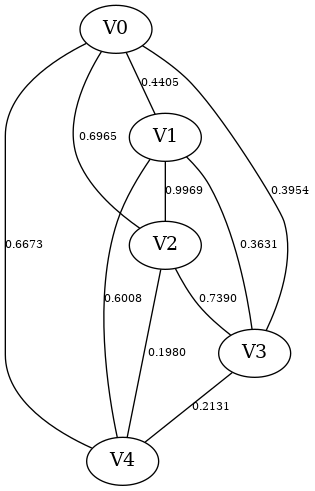

In [3]:
def draw_graph(graph: Graph, highlight: Optional[List[Edge]] = None) -> Image.Image:
  vertices, edges = graph
  viz = pgv.AGraph()
  viz.add_nodes_from(vertices)
  for v, w, cost in edges:
    color="red" if highlight is not None and ((v,w,cost) in highlight or (w,v,cost) in highlight) else "black"
    viz.add_edge(v, w, label=f"{cost:.4f}", color=color)
  viz.layout(prog="dot", args="-Efontsize=8 -Elabeldist=20")
  stream = BytesIO(viz.draw(format="png"))
  return Image.open(stream)

if __name__ == "__main__":
  graph = generate_random_graph(min_num_vertices=5, max_num_vertices=5)
  display.display(draw_graph(graph))

In [4]:
def serialize_graphs(fp: BinaryIO, *graphs: List[Graph]) -> BinaryIO:
  for i, graph in enumerate(graphs):
    vertices, edges = graph
    if i > 0:
      fp.write(b"\n")
    fp.write(b"V")
    fp.write(",".join(vertices).encode("utf-8"))
    fp.write(f"\nN{len(edges)}".encode("utf-8"))
    for w,v,cost in edges:
      fp.write(f"\nE{w},{v},{cost}".encode("utf-8"))
  return fp

def deserialize_graphs(fp: BinaryIO) -> Tuple[List[Graph], List[int]]:
  graphs: List[Graph] = []
  graph_end_positions: List[int] = []
  try:
    while len(line := fp.readline().decode("utf-8")) > 0:
      assert line.startswith("V")
      vertices = line[1:].strip().split(",")
      num_edges_line = fp.readline().decode("utf-8").strip()
      assert num_edges_line.startswith("N")
      num_edges = int(num_edges_line[1:])
      edges: List[Edge] = []
      for _ in range(num_edges):
        edge_line = fp.readline().decode("utf-8").strip()
        assert edge_line.startswith("E")
        edge_data = edge_line[1:].split(",")
        assert len(edge_data) == 3
        edge: Edge = (edge_data[0], edge_data[1], float(edge_data[2]))
        edges.append(edge)
      graphs.append((vertices, edges))
      graph_end_positions.append(fp.tell()-1)
  except Exception:
    traceback.print_exc()
    print(f"Managed to successfully recover {len(graphs)} graphs")
  return graphs, graph_end_positions

In [5]:
if __name__ == "__main__":
  num_graphs_to_generate = 10000

  sample_graphs_path = "sample_graphs.dat"
  sample_graphs: List[Graph] = []
  if os.path.exists(sample_graphs_path):
    with open(sample_graphs_path, "r+b") as fp:
      sample_graphs, graph_end_positions = deserialize_graphs(fp)
      fp.seek(graph_end_positions[-1])
      fp.truncate()
    
    print(f"Loaded {len(sample_graphs)}/{num_graphs_to_generate} ({100*(len(sample_graphs)/num_graphs_to_generate):.2f})% sample graphs")
  
  if len(sample_graphs) < num_graphs_to_generate:
    def make_graph(q: "Queue[Tuple[str, Optional[Graph]]]"):
      graph = generate_random_graph(max_num_vertices=30)
      q.put(("SERIALIZE", graph))
      return graph
    
    def listener(q: "Queue[Tuple[str, Optional[Graph]]]", graphs: List[Graph]):
      while True:
        cmd, arg = q.get()
        if cmd == "STOP":
          break
        elif cmd == "SERIALIZE":
          graphs.append(arg)
          with open(sample_graphs_path, "wb" if len(graph) == 1 else "ab") as fp:
            if len(graphs) > 1:
              fp.write(b"\n")
            serialize_graphs(fp, arg)
        else:
          raise AssertionError(f"Unknown command: {cmd}")
    
    manager = Manager()
    q: "Queue[Tuple[str, Optional[Graph]]]" = manager.Queue()
    l = Thread(target=listener, args=(q, sample_graphs), daemon=True)
    l.start()
    process_map(make_graph, [q]*(num_graphs_to_generate-len(sample_graphs)), max_workers=5, tqdm_class=tqdm, chunksize=1000)
    q.put(("STOP", None))
    l.join()
    print(f"Got {len(sample_graphs)}/{num_graphs_to_generate} ({100*(len(sample_graphs)/num_graphs_to_generate):.2f})% sample graphs")

  assert len(np.unique(np.array(list(str(g) for g in sample_graphs)))) == num_graphs_to_generate, "Set contains duplicates"

Loaded 10000/10000 (100.00)% sample graphs
